In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import streamlit as st
import joblib

In [32]:
# Step 1: Load the dataset
file_path = 'ConsumerElectronics.csv'  # Replace with your dataset path
data = pd.read_csv(file_path)

C:\Users\Gajen\AppData\Local\Temp\ipykernel_29576\3942256275.py:3: DtypeWarning: Columns (6,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [33]:
# Step 2: Data understanding
# Let's check the basic info about the dataset
print(data.info())
print(data.describe())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648824 entries, 0 to 1648823
Data columns (total 20 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   fsn_id                           1648824 non-null  object 
 1   order_date                       1648824 non-null  object 
 2   Year                             1648824 non-null  int64  
 3   Month                            1648824 non-null  int64  
 4   order_id                         1648824 non-null  float64
 5   order_item_id                    1648824 non-null  float64
 6   gmv                              1648824 non-null  object 
 7   units                            1648824 non-null  int64  
 8   deliverybdays                    1648824 non-null  object 
 9   deliverycdays                    1648824 non-null  object 
 10  s1_fact.order_payment_type       1648824 non-null  object 
 11  sla                              1648824 non-null 

In [34]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values)


Missing values in each column:
 fsn_id                             0
order_date                         0
Year                               0
Month                              0
order_id                           0
order_item_id                      0
gmv                                0
units                              0
deliverybdays                      0
deliverycdays                      0
s1_fact.order_payment_type         0
sla                                0
cust_id                            0
pincode                            0
product_analytic_super_category    0
product_analytic_category          0
product_analytic_sub_category      0
product_analytic_vertical          0
product_mrp                        0
product_procurement_sla            0
dtype: int64


In [35]:
# Step 3: Data Preprocessing

# Convert 'order_date' to datetime
data['order_date'] = pd.to_datetime(data['order_date'], errors='coerce')

# Handle missing values (Drop rows with missing or invalid data)
data = data.dropna()

# Remove any duplicates in the dataset
data = data.drop_duplicates()

# Extract features from 'order_date' (like Day of the Week and Month)
data['Order_Day'] = data['order_date'].dt.day
data['Order_Month'] = data['order_date'].dt.month
data['Order_Day_of_Week'] = data['order_date'].dt.dayofweek

# Step 4: Feature Engineering

# Define special sales days (for example, Black Friday, Christmas, New Year)
special_sale_days = ['2015-11-27', '2015-12-25', '2016-01-01']  # Black Friday, Christmas, New Year

# Create a 'Holiday_Flag' for special sale days
data['Holiday_Flag'] = np.where(data['order_date'].isin(pd.to_datetime(special_sale_days)), 1, 0)

# Adding "Pay Date" flag (assuming 1st and 15th of each month as pay dates)
data['Pay_Date_Flag'] = np.where(data['order_date'].dt.day.isin([1, 15]), 1, 0)

# Step 5: Creating GMV per Unit and Discount Percentage

# Create GMV per Unit and Discount Percentage columns
# Ensure the correct column names for GMV ('gmv') and 'units' are used
data['GMV_per_Unit'] = pd.to_numeric(data['gmv'], errors='coerce') / data['units']

# Calculate discount percentage based on 'product_mrp' and 'GMV_per_Unit'
data['Discount'] = (data['product_mrp'] - data['GMV_per_Unit']) / data['product_mrp'] * 100

# Handle any remaining missing or infinite values in 'GMV_per_Unit' and 'Discount'
data = data.replace([np.inf, -np.inf], np.nan).dropna(subset=['GMV_per_Unit', 'Discount'])

# Step 6: Check the updated dataset after feature engineering
print(data.head())


             fsn_id          order_date  Year  Month      order_id  \
0  ACCCX3S58G7B5F6P 2015-10-17 15:11:54  2015     10  3.419301e+15   
1  ACCCX3S58G7B5F6P 2015-10-19 10:07:22  2015     10  1.420831e+15   
2  ACCCX3S5AHMF55FV 2015-10-20 15:45:56  2015     10  2.421913e+15   
3  ACCCX3S5AHMF55FV 2015-10-14 12:05:15  2015     10  4.416592e+15   
4  ACCCX3S5AHMF55FV 2015-10-17 21:25:03  2015     10  4.419525e+15   

   order_item_id   gmv  units deliverybdays deliverycdays  ...  \
0   3.419301e+15  6400      1            \N            \N  ...   
1   1.420831e+15  6900      1            \N            \N  ...   
2   2.421913e+15  1990      1            \N            \N  ...   
3   4.416592e+15  1690      1            \N            \N  ...   
4   4.419525e+15  1618      1            \N            \N  ...   

  product_analytic_vertical  product_mrp product_procurement_sla Order_Day  \
0              CameraTripod         7190                       0        17   
1              CameraTripo

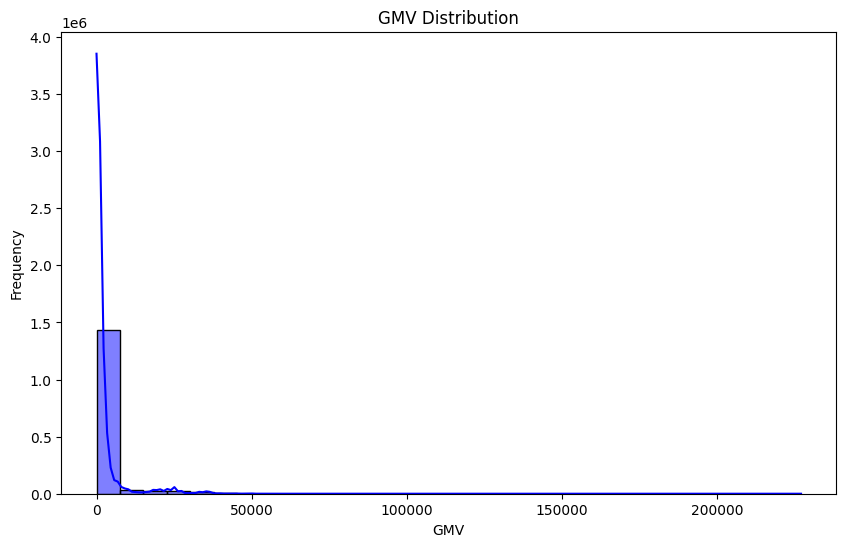

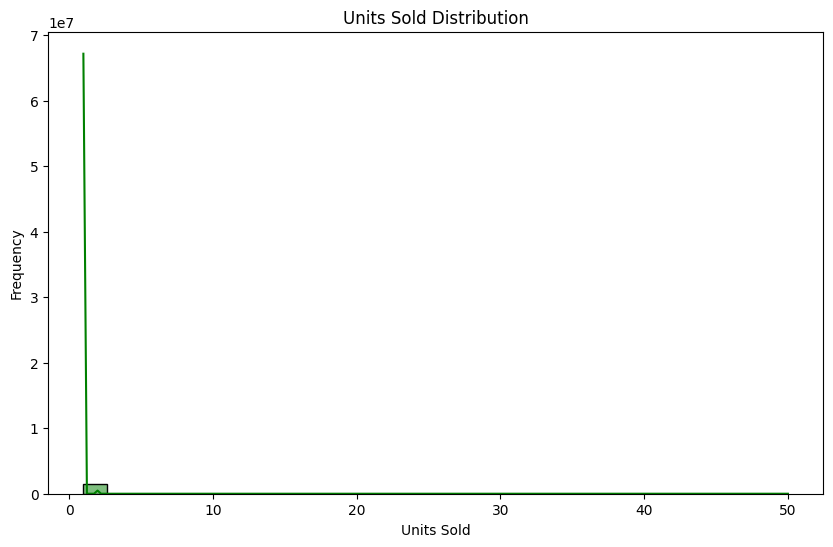

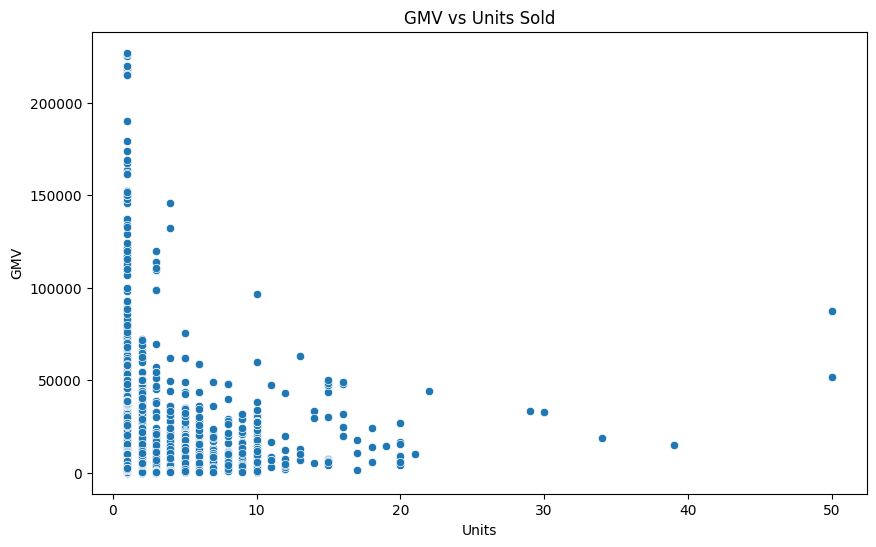

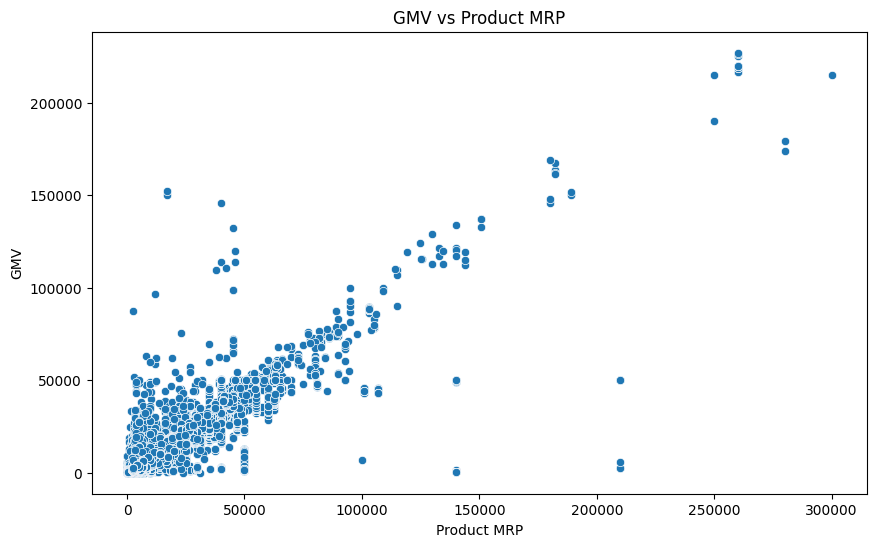

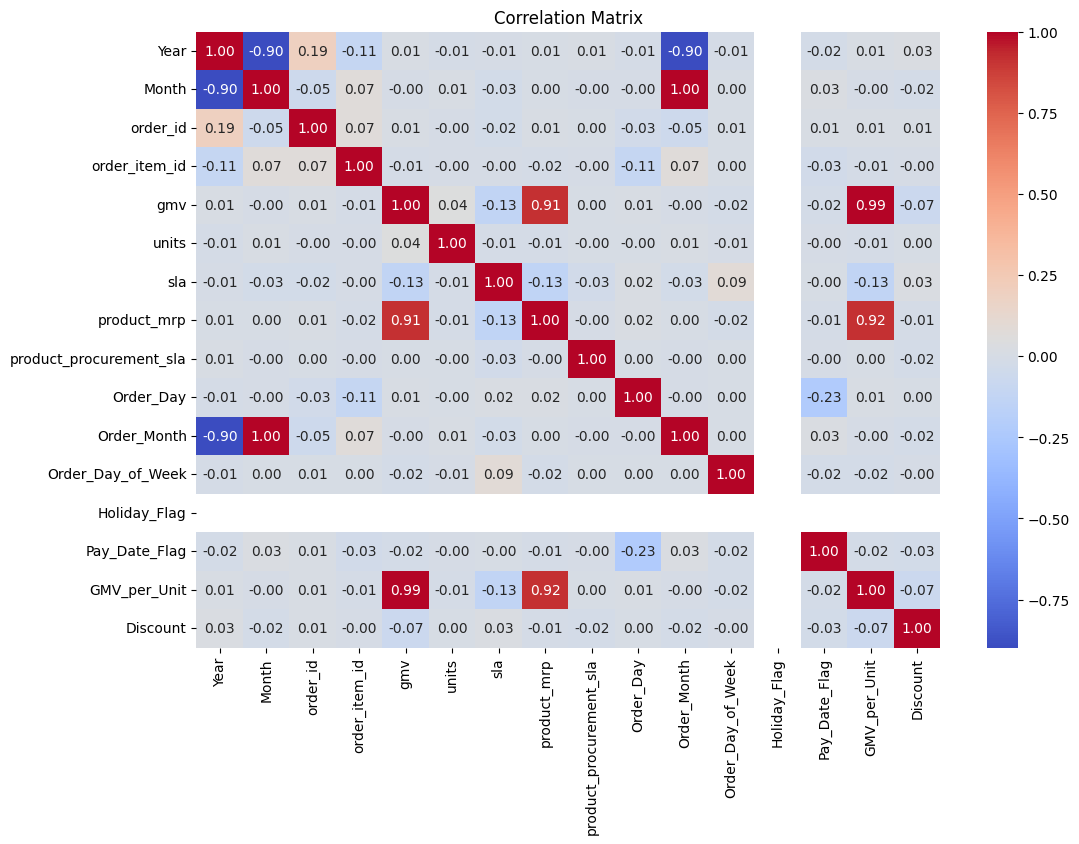

In [36]:
# Step 1: Convert 'gmv' to numeric
data['gmv'] = pd.to_numeric(data['gmv'], errors='coerce')

# Optionally, drop rows with NaN values in 'gmv' if desired
data = data.dropna(subset=['gmv'])

# Step 4: Exploratory Data Analysis (EDA)

import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of GMV (target variable)
plt.figure(figsize=(10, 6))
sns.histplot(data['gmv'], bins=30, kde=True, color='blue')
plt.title('GMV Distribution')
plt.xlabel('GMV')
plt.ylabel('Frequency')
plt.show()

# Distribution of Units sold
plt.figure(figsize=(10, 6))
sns.histplot(data['units'], bins=30, kde=True, color='green')
plt.title('Units Sold Distribution')
plt.xlabel('Units Sold')
plt.ylabel('Frequency')
plt.show()

# Bivariate Analysis: GMV vs Units Sold
plt.figure(figsize=(10, 6))
sns.scatterplot(x='units', y='gmv', data=data)
plt.title('GMV vs Units Sold')
plt.xlabel('Units')
plt.ylabel('GMV')
plt.show()

# Bivariate Analysis: GMV vs Product MRP
plt.figure(figsize=(10, 6))
sns.scatterplot(x='product_mrp', y='gmv', data=data)
plt.title('GMV vs Product MRP')
plt.xlabel('Product MRP')
plt.ylabel('GMV')
plt.show()

# Correlation Heatmap
# Select only numeric columns for correlation
numeric_data = data.select_dtypes(include=['number'])

# Check if we have any numeric columns left
if not numeric_data.empty:
    plt.figure(figsize=(12, 8))
    sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()
else:
    print("No numeric columns available for correlation.")


In [37]:
# Step 5: Feature Selection

# First, check the actual column names in the DataFrame to ensure correctness
print(data.columns)

# Select important features (ensure column names match your DataFrame)
selected_features = ['units', 'product_mrp', 'Discount', 'Holiday_Flag', 'Pay_Date_Flag', 'Order_Day', 'Order_Month']

# Split the data into features (X) and target (y)
# Ensure the selected features exist in the DataFrame
X = data[selected_features]

# Make sure the target variable 'gmv' is available and named correctly
y = data['gmv']  # Target variable (use lowercase to match the updated DataFrame)

# Check if the features and target are correctly defined
print("Feature set (X):")
print(X.head())

print("Target variable (y):")
print(y.head())


Index(['fsn_id', 'order_date', 'Year', 'Month', 'order_id', 'order_item_id',
       'gmv', 'units', 'deliverybdays', 'deliverycdays',
       's1_fact.order_payment_type', 'sla', 'cust_id', 'pincode',
       'product_analytic_super_category', 'product_analytic_category',
       'product_analytic_sub_category', 'product_analytic_vertical',
       'product_mrp', 'product_procurement_sla', 'Order_Day', 'Order_Month',
       'Order_Day_of_Week', 'Holiday_Flag', 'Pay_Date_Flag', 'GMV_per_Unit',
       'Discount'],
      dtype='object')
Feature set (X):
   units  product_mrp   Discount  Holiday_Flag  Pay_Date_Flag  Order_Day  \
0      1         7190  10.987483             0              0         17   
1      1         7190   4.033380             0              0         19   
2      1         2099   5.192949             0              0         20   
3      1         2099  19.485469             0              0         14   
4      1         2099  22.915674             0              0      

In [38]:
# Step 6: Split the data into training and test sets
from sklearn.model_selection import train_test_split

# Ensure that X and y are properly defined
# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Test target shape:", y_test.shape)


Training set shape: (1228024, 7)
Test set shape: (307007, 7)
Training target shape: (1228024,)
Test target shape: (307007,)


In [39]:
# Step 7: Model Building - Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Build a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions for training and testing sets
y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

# Model Evaluation - Linear Regression
train_mse_lr = mean_squared_error(y_train, y_train_pred_lr)
train_r2_lr = r2_score(y_train, y_train_pred_lr)
test_mse_lr = mean_squared_error(y_test, y_test_pred_lr)
test_r2_lr = r2_score(y_test, y_test_pred_lr)

# Print evaluation metrics
print(f"Linear Regression - Train MSE: {train_mse_lr:.2f}, Train R²: {train_r2_lr:.2f}")
print(f"Linear Regression - Test MSE: {test_mse_lr:.2f}, Test R²: {test_r2_lr:.2f}")


Linear Regression - Train MSE: 5127409.76, Train R²: 0.84
Linear Regression - Test MSE: 5225736.89, Test R²: 0.83


In [40]:
# Step 8: Model Building - Random Forest
from sklearn.ensemble import RandomForestRegressor

# Build a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions for training and testing sets
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Model Evaluation - Random Forest
train_mse_rf = mean_squared_error(y_train, y_train_pred_rf)
train_r2_rf = r2_score(y_train, y_train_pred_rf)
test_mse_rf = mean_squared_error(y_test, y_test_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)

# Print evaluation metrics
print(f"Random Forest - Train MSE: {train_mse_rf:.2f}, Train R²: {train_r2_rf:.2f}")
print(f"Random Forest - Test MSE: {test_mse_rf:.2f}, Test R²: {test_r2_rf:.2f}")


Random Forest - Train MSE: 5155.43, Train R²: 1.00
Random Forest - Test MSE: 25732.05, Test R²: 1.00


In [48]:
# Print the columns in the DataFrame to check what's available
print("Columns in the DataFrame:", data.columns.tolist())


Columns in the DataFrame: ['fsn_id', 'order_date', 'Year', 'Month', 'order_id', 'order_item_id', 'gmv', 'units', 'deliverybdays', 'deliverycdays', 's1_fact.order_payment_type', 'sla', 'cust_id', 'pincode', 'product_analytic_super_category', 'product_analytic_category', 'product_analytic_sub_category', 'product_analytic_vertical', 'product_mrp', 'product_procurement_sla', 'Order_Day', 'Order_Month', 'Order_Day_of_Week', 'Holiday_Flag', 'Pay_Date_Flag', 'GMV_per_Unit', 'Discount']


In [46]:
selected_features = ['units', 'product_mrp', 'Discount', 'Holiday_Flag', 'Pay_Date_Flag', 'Order_Day', 'Order_Month']


In [49]:
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Assuming 'data' is your DataFrame and has been prepared earlier

# Step 1: Print the columns in the DataFrame to check what's available
print("Columns in the DataFrame:", data.columns.tolist())

# Update this list based on the actual column names printed above
selected_features = ['units', 'product_mrp', 'Discount', 'Holiday_Flag', 'Pay_Date_Flag', 'Order_Day', 'Order_Month']  # Update as needed

# Step 2: Check for missing features
missing_features = [feature for feature in selected_features if feature not in data.columns]
if missing_features:
    raise ValueError(f"The following features are missing from the DataFrame: {missing_features}")

# Step 3: Create feature matrix and target variable
X = data[selected_features]
y = data['gmv']  # Target variable (make sure to use the correct casing)

# Step 4: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Model Building - Neural Network (MLP Regressor)
# Build a Neural Network model
nn_model = MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=500, random_state=42)
nn_model.fit(X_train, y_train)

# Predictions for training and testing sets
y_train_pred_nn = nn_model.predict(X_train)
y_test_pred_nn = nn_model.predict(X_test)

# Step 6: Model Evaluation - Neural Network
train_mse_nn = mean_squared_error(y_train, y_train_pred_nn)
train_r2_nn = r2_score(y_train, y_train_pred_nn)
test_mse_nn = mean_squared_error(y_test, y_test_pred_nn)
test_r2_nn = r2_score(y_test, y_test_pred_nn)

# Print evaluation metrics
print(f"Neural Network - Train MSE: {train_mse_nn:.2f}, Train R²: {train_r2_nn:.2f}")
print(f"Neural Network - Test MSE: {test_mse_nn:.2f}, Test R²: {test_r2_nn:.2f}")

# Step 7: Model Interpretation - Feature Importance for Random Forest
# Assuming rf_model is defined and trained elsewhere in your code
# Ensure the rf_model is trained before running this part

# Create a DataFrame to hold feature importances
# Make sure rf_model is fitted before this line
rf_feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': rf_model.feature_importances_  # Assuming rf_model is already fitted
}).sort_values(by='Importance', ascending=False)

# Display feature importance
print("Random Forest Feature Importance:\n", rf_feature_importance)


Columns in the DataFrame: ['fsn_id', 'order_date', 'Year', 'Month', 'order_id', 'order_item_id', 'gmv', 'units', 'deliverybdays', 'deliverycdays', 's1_fact.order_payment_type', 'sla', 'cust_id', 'pincode', 'product_analytic_super_category', 'product_analytic_category', 'product_analytic_sub_category', 'product_analytic_vertical', 'product_mrp', 'product_procurement_sla', 'Order_Day', 'Order_Month', 'Order_Day_of_Week', 'Holiday_Flag', 'Pay_Date_Flag', 'GMV_per_Unit', 'Discount']


c:\Users\Gajen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Neural Network - Train MSE: 1012052.28, Train R²: 0.97
Neural Network - Test MSE: 1036078.74, Test R²: 0.97
Random Forest Feature Importance:
          Feature  Importance
1    product_mrp    0.891902
2       Discount    0.094468
0          units    0.013528
6    Order_Month    0.000056
5      Order_Day    0.000042
4  Pay_Date_Flag    0.000004
3   Holiday_Flag    0.000000


The output you've provided contains the results of a machine learning modeling process involving a Neural Network and a Random Forest model. Let's break down the key components:

1. Neural Network Metrics
Train MSE (Mean Squared Error):

Value: 1,012,052.28
Interpretation: This value indicates the average squared difference between the predicted and actual values of the target variable (GMV) for the training dataset. A lower MSE value signifies better model performance, but the absolute value is less informative without context about the scale of GMV.
Train R² (Coefficient of Determination):

Value: 0.97
Interpretation: This value means that 97% of the variance in the target variable (GMV) can be explained by the model using the features in the training set. An R² value close to 1 indicates that the model fits the training data very well.
Test MSE (Mean Squared Error):

Value: 1,036,078.74
Interpretation: This value represents the average squared difference between the predicted and actual values of GMV for the test dataset. Again, a lower value is preferable, and the proximity of the test MSE to the train MSE suggests that the model generalizes well to unseen data.
Test R² (Coefficient of Determination):

Value: 0.97
Interpretation: Similar to the training R², this value indicates that 97% of the variance in GMV can be explained by the model using the features in the test set. The high R² value confirms that the model is effectively capturing the relationships in the data.
2. Random Forest Feature Importance
Feature importance values provide insights into how much each feature contributes to the model's predictions.

Feature	Importance
product_mrp	0.891902
Discount	0.094468
units	0.013528
Order_Month	0.000056
Order_Day	0.000042
Pay_Date_Flag	0.000004
Holiday_Flag	0.000000
Interpretation of Feature Importance:
product_mrp: This feature has the highest importance score (0.891902), indicating it is the most significant predictor of GMV in the Random Forest model. It suggests that the product's maximum retail price has a strong influence on the sales generated.

Discount: With an importance score of 0.094468, this feature also plays a role but is significantly less important than product_mrp. This indicates that the discounts offered do affect GMV but to a lesser extent.

units: This feature's importance score (0.013528) suggests it has a minimal impact on the prediction of GMV. This may imply that simply the number of units sold is not as crucial as other features.

Order_Month, Order_Day, Pay_Date_Flag, Holiday_Flag: These features have very low importance scores, indicating that they have negligible influence on the GMV predictions. The Holiday_Flag, in particular, has an importance score of 0, suggesting it does not contribute at all to the model's predictions in this context.

Summary
Overall, the results indicate that:

Your Neural Network model is performing very well on both training and test datasets, as indicated by low MSE values and high R² scores.
The Random Forest model highlights the overwhelming influence of the product's maximum retail price on GMV, with discounts being a secondary factor. Other features seem to contribute little to the model's predictive power.
These insights can guide marketing and pricing strategies by emphasizing the importance of product pricing over other variables when trying to optimize sales.